In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

# Tuesday
* midi done. There was an error in how I was processing the memory block (for loop indexes!) and also I'd forgotten entirely a whole block of code in the gotMsg() function
* Now working well.
* Next, make a Python synth as an example.
* + maybe a vocoder
* + add a param to the ui "use internal synth" (done) and maybe a sine/square option (hard in Juce, just go to Python!)
* I probably should add a thing so bpm is transmitted with every packet.

# Mon
* pratted around with getting midi back. It's there, just not returning to the calling function (processBlock in c++). Bit fucky.

# Sun
* midi should be xmit + recv + played, it does seem to be working correctly in that you flip the "process midi" switch and midi is correctly played, but not the modified version.
* yep certainly the returned midi (zeros!) is not being written to the buf in C++.
* (Much later...) Midi is def being returned to c++ but it crashes badly on being written to tmpMidi[i].
* * There's something wrong with the sizeing of things, or maybe 2 pointers accessing the same thing, idk.

# Random note
* LSTM or sth has got to be good for storing hidden state in between 10ms(480 samps) blocks! Store hidden state and feed it back.
* Also will have to store some kind of state (e.g. 2 waveforms) to respond to midi, keep it going on the subsequent blocks until note off received.

# Sat
* Got BPM transmitted to python and displayed in VST, easy to add timesig if ness
* Test VST within a DAW... (eg my new mixcraft9!)
* midi is being transmitted and decoded in python. And transmitted back, albeit the unmodified version.
* Test if callback returns tuple (audio and midi) or just audio (or midi), and return to cpp accordingly. (ie if one was unmodified, return it as transmitted)
* set midi in messageReceived in cpp, then act on that in the processBlock function (there's a bit of chaining i'll need to do)
* make a demo using bpm (e.g. just to decrease freq of audio signal as bpm goes up (pitchshifter!)) and midi (e.g. vocoder!)
* some belt and braces stuff e.g. make a pip installable library, package vst... then TOTALLY DONE!!

# Fri
* Looks like midi data is now being transmitted into VSTSender2!
* Learn how to interpret this...
* Response is not being transmitted or interpreted properly (EDIT: I added the `msg2 += b'0'*200` and now it is)
* Allow midi processing! :D Permit the midi data to be (a) returned to the synth or otherwise output from the VST; (b) turned into audio data right in the VSTSender2 notebook (another callback for midi)

# Thurs
* Penix from the flames!!! Ditched LSTM, reshaped attention, BAM it works again for reverse and quant.
* Well I was testing on quant recently (and optimizing for that a bit) but both were working and all seems good nay great.
* (Quant sounds brill and looks fantastic in VSTSender2 and reverse still works too!!!)

# Weds
* Broke everything
* Feels like it *should* be working as I implemented everything correctly I think. But it isn't, in fact got worse. Had some nice smooth outputs but they don't really reflect what the target should be very accurately.
* May have to just give up and start hacking the nn_reverse_train notebook until I figure out what it is that actually breaks it.
* Also, maybe take out LSTM and just try attn.

# Tuesday
* Moos wasn't quite deed but did deed after 30seconds
* Got it working, not great/clean but working.
* Still think there's some prob with my understanding/implementation of lstm + attention. Or maybe just attention since it should obviate the need for lstm. I think right now the lstm impl is correct but attention is bonk.
* batch size def has an impact on the finetuning task, more is worse
* There is definitely some bad reshaping happening, there's this weird peak at 240
* Left it reverted (I think) to the working state. Deeply uncomfortable with how it is rn. LSTM input is the wrong shape given batch_first=True. v should not need reshaping

# Monday
* mouse deeed!!! :x
* suspect various shortcuts I made in nn_reverse_train were hacks and dont really work
* was unable to get this nb working with reverse!!! argh! keep going!
* moos deed :(
* so sad

# Sunday
* Made several improvements
* Got the loss really low by removing the LSTM (GRU is better) and making v a transform of x, but it didn't work to reverse the seuqnece.
* Try making v a transpose of k so it can pick from the whole sequence. (DONE, fail)
* Get the same "attention-only" arch working to reverse the seq as well and I am DONE! FINALLY! but that seems hard
* Really, this sucks. Got quantize arch working great and then it doesn't work with reverse. Arrgh. Revert back to reverse arch bit by bit until I find out what it was that changed that bonked everything. (I did try reinstating LSTM naievely, but it failed.) GOOF

# Saturday
* Fixed sines=True & checked inputs/outputs are right
* Deleted positional encoding, it's useless without attention mask/inputs that can be different lengths
* Changed how loss gets shown thru epochs :)
* Got batchnorm1d and 2d working, seemed to improve loss but actually gave some odd outputs (not def bad just odd)
*NEXT*
* layernorm0 seems useless. actually seems to make it unable to learn, just replicate the input. probs it has to be after a nonlinearity or attn or lstm or sth. (removed it)
* what happens when I remove the torch.add residual now?
* ensure MyCallback does a max(1) min(-1) on its output (done)
*swapped norm2 and lin. seems worse overall, not learning? but also good (undid it, reverted)
* make k a transformation of x, not just ==q (done)
* now using mseloss for everything, seems better (maybe now that it all works)
* there is a VERY BIG DIFFERENCE between the net's preds and what it should look like. The first seems correctly quantized per four units. The second seems quantized per MANY units, (hence why it looks stepwise). What/WHY. At this point it really may just be a matter of bumping the layer sizes/params...


# Friday
* Stereo is back just by treating it as a bs=2 in VSTSender2-mono
* Had some really good sounds, low/very low hum + hiss
* I don't think sines=True works properly
* Still didn't add more layernorm or any batchnorm
* Something I did - maybe the Resnet (!!!) arch where i do torch.add(x,y) -- made it clicky on transients. Fix that.

In [305]:
class Net (torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.embed_sz = 1
        self.proj_sz = 8
        self.lstm_h = 1
        self.filter_size = 5
        self.intra_size = 1
        
        self.norm = nn.LayerNorm((480, self.intra_size)).cuda()
        
        
        self.l0 = torch.nn.Linear(1, self.embed_sz, bias=False).cuda()
        
        self.attn = torch.nn.MultiheadAttention(480, 1, bias=False)
        self.attn_out = nn.Linear(1, 1, bias=False).cuda()
        
        self.l3 = torch.nn.Linear(1, self.intra_size, bias=False).cuda()
        self.lstm_out = nn.Linear(2, 1, bias=False).cuda()
        self.l_tmp = nn.Linear(self.embed_sz, self.intra_size, bias=False).cuda()
        
        self.kernel = torch.nn.Parameter(torch.rand((self.intra_size, self.intra_size, self.filter_size), device='cuda') - 0.5, requires_grad=True)
        
    def forward(self, x):
        bs = x.size(0)
        x = self.l0(x)
        x = x.view(bs, 1, 480)
        
        q, k, v = x, x, x
        
        x, _ = self.attn(q, k, v)
        
        x = x.view(bs, -1, 1)
        
        
        
        x = self.attn_out(x)
        x = torch.tanh(x) #<---try softmax here (I did, it was worse)
        #x = torch.add(x, v) #<- makes it worse
        #x = self.norm(x)
        
        x = self.l3(x)
        
        padded = F.pad(x.permute(0, 2, 1), ((self.filter_size//2), (self.filter_size//2)), mode='replicate')
        x = F.conv1d(padded, self.kernel)
        x = x.permute(0, 2, 1)
        
        return x


In [306]:
class DataGenerator(Dataset):
    def __init__(self, sines=False, zeros_if_lt=3):
        super().__init__()
        self.sines = sines
        self.zeros_if_lt = zeros_if_lt

    def __len__(self):
        return int(1e4)

    def __getitem__(self, idx):
        if self.sines:
            freq = random.randint(10, 300000)
            freq = freq / 100
            x = torch.sin(2*np.pi*torch.arange(96000*0.01, device="cuda")*freq/96000)
            x = x.unsqueeze(-1)
            x = x * (random.random() * random.choice([1, -1]))
            # now take a 480 slice of that
            start_idx = random.randint(0, 479)
            end_idx = start_idx + 480
            x = x[start_idx:end_idx, :]
            # not sure why i was deliberately introducing a bias!?
            #x = (x + random.random()) - 0.5
        else:
            x = torch.rand((480, 1), device='cuda')
            x = (x / torch.max(x) - 0.5) * 2
        #repeat = torch.repeat_interleave(x[::16, :], 16, dim=0)
        #target = torch.quantize_per_channel(repeat.cpu(), torch.tensor([0.3]).repeat((480,)), torch.tensor([0]).repeat((480, )), 0, dtype=torch.qint32)
        #target = torch.dequantize(target).cuda()
        target = x.flip(0)
        if random.randint(0, 100) < self.zeros_if_lt:
            x = x / 1e6
            target = torch.zeros_like(x)
        return x, target

In [307]:
net = Net()
net.to('cuda')

Net(
  (norm): LayerNorm((480, 1), eps=1e-05, elementwise_affine=True)
  (l0): Linear(in_features=1, out_features=1, bias=False)
  (attn): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=480, out_features=480, bias=True)
  )
  (attn_out): Linear(in_features=1, out_features=1, bias=False)
  (l3): Linear(in_features=1, out_features=1, bias=False)
  (lstm_out): Linear(in_features=2, out_features=1, bias=False)
  (l_tmp): Linear(in_features=1, out_features=1, bias=False)
)

In [308]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
loss_fn = torch.nn.L1Loss() # L1 def seems better than MSELoss

In [309]:
dataloader = DataLoader(DataGenerator(sines=False, zeros_if_lt=0), batch_size=16)
for i in range(100):
    epoch_loss = 0.
    for j, batch in enumerate(dataloader):
        inputs, targets = batch
        output = net(inputs)
        loss = loss_fn(output, targets)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        net.zero_grad()
        optimizer.zero_grad()
    print(f"Epoch {i} avg loss: {epoch_loss / j}")

Epoch 0 avg loss: 0.5018304328983411
Epoch 1 avg loss: 0.4886480906548408
Epoch 2 avg loss: 0.33231522534520197
Epoch 3 avg loss: 0.2334955402243978
Epoch 4 avg loss: 0.16134401561262515
Epoch 5 avg loss: 0.09994035595072767
Epoch 6 avg loss: 0.050121711143173084
Epoch 7 avg loss: 0.028664650204472054
Epoch 8 avg loss: 0.02267060048567752
Epoch 9 avg loss: 0.019778645949629255
Epoch 10 avg loss: 0.01780950808778214
Epoch 11 avg loss: 0.01671192066397709
Epoch 12 avg loss: 0.01593405203983331
Epoch 13 avg loss: 0.015346607656027071
Epoch 14 avg loss: 0.014913574695431938
Epoch 15 avg loss: 0.014497591903469024
Epoch 16 avg loss: 0.014192727097393706
Epoch 17 avg loss: 0.01395617630213308
Epoch 18 avg loss: 0.013711314672269883
Epoch 19 avg loss: 0.01354792069655676
Epoch 20 avg loss: 0.013362910316433184
Epoch 21 avg loss: 0.013228329156752294
Epoch 22 avg loss: 0.013079293354306944


KeyboardInterrupt: 

In [314]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
loss_fn = torch.nn.L1Loss() # def seems better than MSELoss
dataloader = DataLoader(DataGenerator(sines=True, zeros_if_lt=2), batch_size=8)
# bump zeros_if_lt==90 for a serious massive noise reduction after the first round of training!

In [315]:
# Let's do some "finetuning" on sine waves now it's pretrained on noise!
for i in range(30):
    epoch_loss = 0.
    for j, batch in enumerate(dataloader):
        inputs, targets = batch
        output = net(inputs)
        loss = loss_fn(output, targets)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        net.zero_grad()
        optimizer.zero_grad()
    print(f"Epoch {i} avg loss: {epoch_loss / j}")

Epoch 0 avg loss: 0.05806625239905999
Epoch 1 avg loss: 0.05207936142088832
Epoch 2 avg loss: 0.04880041380735745
Epoch 3 avg loss: 0.04674225722180845
Epoch 4 avg loss: 0.04611677832243811
Epoch 5 avg loss: 0.0455591745027382
Epoch 6 avg loss: 0.044182527242146365
Epoch 7 avg loss: 0.043289227206095925
Epoch 8 avg loss: 0.041656865725283314
Epoch 9 avg loss: 0.042977317136819


KeyboardInterrupt: 

In [334]:
torch.save(net.state_dict(), "quant_net_960_mono.bin")

In [329]:
freq = 491
x = torch.sin(2*np.pi*torch.arange(96000*0.01)*freq/96000).view(-1, 1)
x = x * (random.random() * random.choice([1, -1]))
start_idx = random.randint(0, 479)
end_idx = start_idx + 480
x = x[start_idx:end_idx, :]

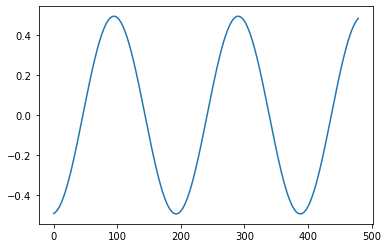

In [330]:
plt.plot(x)

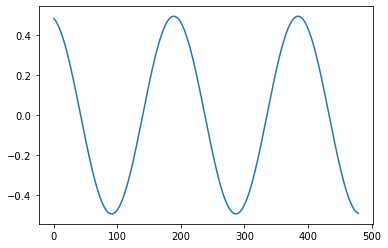

In [331]:
plt.plot(x.flip(0))

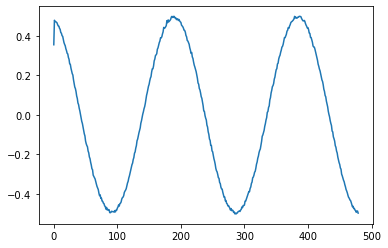

In [332]:
net.eval()
plt.plot(net(x.unsqueeze(0).cuda())[0].detach().cpu().numpy())
net.train();

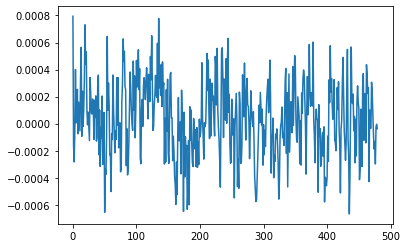

In [333]:
net.eval()
plt.plot(net(torch.zeros((2, 480, 1), device='cuda'))[0].detach().cpu().numpy())
net.train();

In [246]:
repeat = torch.repeat_interleave(x[::4, :], 4, dim=0)
target = torch.quantize_per_channel(repeat.cpu(), torch.tensor([0.3]).repeat((480,)), torch.tensor([0]).repeat((480, )), 0, dtype=torch.qint32)
target = torch.dequantize(target).numpy()

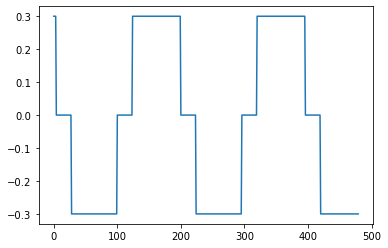

In [247]:
plt.plot(target)

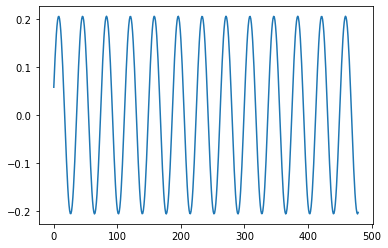

In [1307]:
plt.plot(targets[1].cpu().numpy())

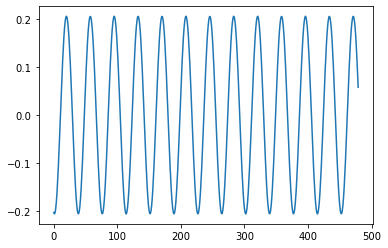

In [1308]:
plt.plot(inputs[1].cpu().numpy())

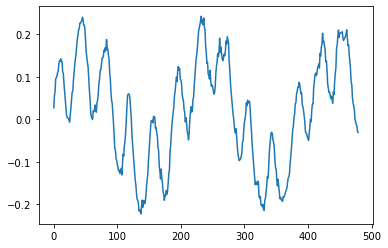

In [1309]:
plt.plot(net(inputs)[0].detach().cpu().numpy())